#Fine tuning LLM model

In [60]:
!pip install -q -U bitsandbytes #for reducing floating bits size of training parameters
# !pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install transformers==4.31
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install -U trl peft
!pip install evaluate
!pip install -qqq trl==0.7.1 #helpful library for fine tuning llm for both supervised and rlhf fine tuning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [61]:
import torch
import time
import evaluate
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import random

In [62]:
df=pd.read_excel("/content/final_dataset.xlsx")

df.head()

,Unnamed: 0,Node,Deviation,Cause,Consequence,Effective Safeguards,Recommendations
0,0.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,1.More Flow of Feed,1.Human error - Battery limit Valve left open during Recirculation Mode (Valve FV-11101 Down stream),"1.Level increases in the rerun column with subsequent rise in pressure in the system beyond design pressure. Leak of Benzene with potential for fire, fatality and asset damage.",1.FIC-11101 will give high Flow Alarm,1.Consider providing low temperature alarm on TI-11151
1,1.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,1.Tube rupture of Feed preheater 5E-01N,"1.NMP will enter HC side, process upset, increase in temperature",1.Feed Preheater designed for a pressure of 20 kg / cm2 and it is operated at 6 kg / cm2,2.Consider providing high temperature alarm on TI-11151
2,2.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,1.Tube rupture of Feed preheater 5E-01N,"1.NMP will enter HC side, process upset, increase in temperature",2.TIC-11352 will give high temperature alarm and regulate the 3way Control Valve,2.Consider providing high temperature alarm on TI-11152
3,3.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,2.Tube rupture of NMP reboiler 5E-02,"1.NMP will enter HC side, process upset, increase in Column bottom temperature",1.NMP Reboiler designed for a pressure of 4 kg / cm2 and it is operated at 0.4 kg/ cm2,2.Consider providing high temperature alarm on TI-11153
4,4.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,2.Tube rupture of NMP reboiler 5E-02,"1.NMP will enter HC side, process upset, increase in Column bottom temperature",2.TIC-11111 (steam) will give high temperature alarm,2.Consider providing high temperature alarm on TI-11154


In [63]:
df=df.iloc[:,1:]
df.head()

,Node,Deviation,Cause,Consequence,Effective Safeguards,Recommendations
0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,1.More Flow of Feed,1.Human error - Battery limit Valve left open during Recirculation Mode (Valve FV-11101 Down stream),"1.Level increases in the rerun column with subsequent rise in pressure in the system beyond design pressure. Leak of Benzene with potential for fire, fatality and asset damage.",1.FIC-11101 will give high Flow Alarm,1.Consider providing low temperature alarm on TI-11151
1,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,1.Tube rupture of Feed preheater 5E-01N,"1.NMP will enter HC side, process upset, increase in temperature",1.Feed Preheater designed for a pressure of 20 kg / cm2 and it is operated at 6 kg / cm2,2.Consider providing high temperature alarm on TI-11151
2,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,1.Tube rupture of Feed preheater 5E-01N,"1.NMP will enter HC side, process upset, increase in temperature",2.TIC-11352 will give high temperature alarm and regulate the 3way Control Valve,2.Consider providing high temperature alarm on TI-11152
3,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,2.Tube rupture of NMP reboiler 5E-02,"1.NMP will enter HC side, process upset, increase in Column bottom temperature",1.NMP Reboiler designed for a pressure of 4 kg / cm2 and it is operated at 0.4 kg/ cm2,2.Consider providing high temperature alarm on TI-11153
4,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,2.Tube rupture of NMP reboiler 5E-02,"1.NMP will enter HC side, process upset, increase in Column bottom temperature",2.TIC-11111 (steam) will give high temperature alarm,2.Consider providing high temperature alarm on TI-11154


Data preprocessing

In [64]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [65]:
import pandas as pd
from bs4 import BeautifulSoup
import re

def text_cleaner(text):
    if isinstance(text, float) and pd.isna(text):
        return ""  # Return an empty string for NaN values
    else:
        # Lowercase the text
        newString = str(text).lower()

        # Remove HTML tags
        newString = BeautifulSoup(newString, "lxml").text

        # Remove double quotation marks
        newString = re.sub('"', '', newString)

        # Replace "/" with "or"
        newString = re.sub("/", " or ", newString)
        newString = newString.strip()

        # Remove unwanted characters
        newString = re.sub(r":|-|_", " ", newString)

        # Remove special characters
        newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

        # Tokenize the cleaned text and remove stop words
        tokens = [w for w in newString.split()]

        # Remove extra spaces and join the tokens
        words = [i for i in tokens if len(i) >= 1]

        # Join the words and strip leading/trailing spaces
        return " ".join(words).strip()


Deviation_text = []
for t in df['Deviation']:
    Deviation_text.append(text_cleaner(t))

df['Deviation'] = Deviation_text


In [66]:
# For Node


def text_cleaner(text):
    # Lowercase the text
    newString = text.lower()

    # Remove HTML tags
    newString = BeautifulSoup(newString, "lxml").text

    # Remove double quotation marks
    newString = re.sub('"', '', newString)

    # Replace "/" with "or"
    newString = re.sub("/", " ", newString)
    newString=newString.strip()

    # Remove unwanted characters
    newString = re.sub(r":|-|_", " ", newString)

    # Remove special characters
    newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

    # Tokenize the cleaned text and remove stop words
    tokens = [w for w in newString.split()]

    # Remove extra spaces and join the tokens
    words = [i for i in tokens if len(i) >= 1]

    # Join the words and strip leading/trailing spaces
    return " ".join(words).strip()


Node_text = []
for t in df['Node']:
    Node_text.append(text_cleaner(t))

df['Node']=Node_text

In [67]:
from bs4 import BeautifulSoup
import re

def text_cleaner(text):
    if pd.notnull(text):  # Check if the value is not null
        # Lowercase the text
        newString = text.lower()

        # Remove HTML tags
        newString = BeautifulSoup(newString, "lxml").text

        # Remove double quotation marks
        newString = re.sub('"', '', newString)

        # Replace "/" with " " (space)
        newString = re.sub("/", " ", newString)
        newString = newString.strip()

        # Remove unwanted characters
        newString = re.sub(r":|-|_", " ", newString)

        # Remove special characters
        newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

        # Tokenize the cleaned text and remove stop words
        tokens = [w for w in newString.split()]

        # Remove extra spaces and join the tokens
        words = [i for i in tokens if len(i) >= 1]

        # Join the words and strip leading/trailing spaces
        return " ".join(words).strip()
    else:
        return ""  # Return an empty string for missing values

Cause_text = []
for t in df['Cause']:
    Cause_text.append(text_cleaner(t))

df['Cause'] = Cause_text


In [68]:
# For Consequence


def text_cleaner(text):
    if isinstance(text, str):  # Check if text is a valid string
        # Lowercase the text
        newString = text.lower()

        # Remove HTML tags
        newString = BeautifulSoup(newString, "lxml").text

        # Remove double quotation marks
        newString = re.sub('"', '', newString)

        # Replace "/" with "or"
        newString = re.sub("/", " ", newString)
        newString=newString.strip()

        # Remove unwanted characters
        newString = re.sub(r":|-|_", " ", newString)

        # Remove special characters
        newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

        # Tokenize the cleaned text and remove stop words
        tokens = [w for w in newString.split()]

        # Remove extra spaces and join the tokens
        words = [i for i in tokens if len(i) >= 1]

        # Join the words and strip leading/trailing spaces
        return " ".join(words).strip()
    else:
        return "none"


Consequence_text = []
for t in df['Consequence']:
    Consequence_text.append(text_cleaner(t))

df['Consequence']=Consequence_text

In [69]:
# For Effective Safeguards

def text_cleaner(text):
    if isinstance(text, str):  # Check if text is a valid string
        # Lowercase the text
        newString = text.lower()

        # Remove HTML tags
        newString = BeautifulSoup(newString, "lxml").text

        # Remove double quotation marks
        newString = re.sub('"', '', newString)

        # Replace "/" with "or"
        newString = re.sub("/", " ", newString)
        newString=newString.strip()

        # Remove unwanted characters
        newString = re.sub(r":|-|_", " ", newString)

        # Remove special characters
        newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

        # Tokenize the cleaned text and remove stop words
        tokens = [w for w in newString.split()]

        # Remove extra spaces and join the tokens
        words = [i for i in tokens if len(i) >= 1]

        # Join the words and strip leading/trailing spaces
        return " ".join(words).strip()
    else:
        return "none"


ES_text = []
for t in df['Effective Safeguards']:
    ES_text.append(text_cleaner(t))

df['Effective Safeguards']=ES_text

In [70]:
# For Recommendations


def text_cleaner(text):
    # Lowercase the text
    newString = text.lower()

    # Remove HTML tags
    newString = BeautifulSoup(newString, "lxml").text

    # Remove double quotation marks
    newString = re.sub('"', '', newString)

    # Replace "/" with "or"
    newString = re.sub("/", " or ", newString)
    newString=newString.strip()

    # Remove unwanted characters
    newString = re.sub(r":|-|_", " ", newString)

    # Remove leading numbers followed by a period and optional whitespace OR directly by text
    newString = re.sub(r"^\d+(\.|\b)", "", newString)

    # Remove special characters
    newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

    # Tokenize the cleaned text and remove stop words
    tokens = [w for w in newString.split()]

    # Remove extra spaces and join the tokens
    words = [i for i in tokens if len(i) >= 1]

    # Join the words and strip leading/trailing spaces
    return " ".join(words).strip()


Recommendations_text = []
for t in df['Recommendations']:
    Recommendations_text.append(text_cleaner(t))

df['Recommendations']=Recommendations_text
df.head()

,Node,Deviation,Cause,Consequence,Effective Safeguards,Recommendations
0,1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,1.more flow of feed,1.human error battery limit valve left open during recirculation mode valve fv 11101 down stream,"1.level increases in the rerun column with subsequent rise in pressure in the system beyond design pressure. leak of benzene with potential for fire, fatality and asset damage.",1.fic 11101 will give high flow alarm,consider providing low temperature alarm on ti 11151
1,1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,3.misdirected flow,1.tube rupture of feed preheater 5e 01n,"1.nmp will enter hc side, process upset, increase in temperature",1.feed preheater designed for a pressure of 20 kg cm2 and it is operated at 6 kg cm2,consider providing high temperature alarm on ti 11151
2,1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,3.misdirected flow,1.tube rupture of feed preheater 5e 01n,"1.nmp will enter hc side, process upset, increase in temperature",2.tic 11352 will give high temperature alarm and regulate the 3way control valve,consider providing high temperature alarm on ti 11152
3,1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,3.misdirected flow,2.tube rupture of nmp reboiler 5e 02,"1.nmp will enter hc side, process upset, increase in column bottom temperature",1.nmp reboiler designed for a pressure of 4 kg cm2 and it is operated at 0.4 kg cm2,consider providing high temperature alarm on ti 11153
4,1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,3.misdirected flow,2.tube rupture of nmp reboiler 5e 02,"1.nmp will enter hc side, process upset, increase in column bottom temperature",2.tic 11111 steam will give high temperature alarm,consider providing high temperature alarm on ti 11154


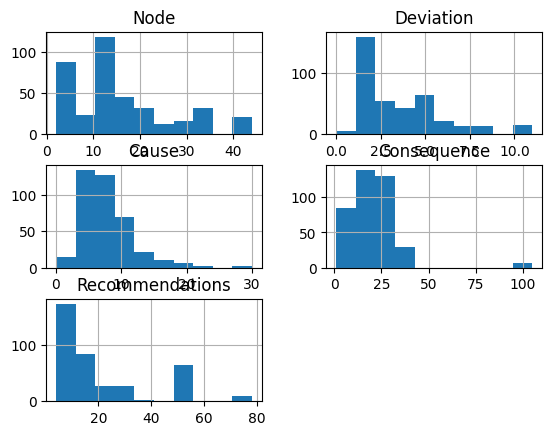

In [71]:

import matplotlib.pyplot as plt
node_count=[]
deviation_count=[]
cause_count=[]
consequence_count	=[]
es_count=[]
Recommendations_count=[]

# populate the lists with sentence lengths
for i in df['Node']:
      node_count.append(len(i.split()))

for i in df['Deviation']:
      deviation_count.append(len(i.split()))
for i in df['Cause']:
      cause_count.append(len(i.split()))
for i in df['Consequence']:
      consequence_count.append(len(i.split()))
for i in df['Effective Safeguards']:
      es_count.append(len(i.split()))
for i in df['Recommendations']:
      Recommendations_count.append(len(i.split()))

length_df = pd.DataFrame({'Node':node_count, 'Deviation':deviation_count,'Cause':cause_count,'Consequence':consequence_count,'Recommendations':Recommendations_count})
length_df.hist(bins = 10)
plt.show()

In [72]:
print(max(node_count)+max(deviation_count)+max(cause_count)+max(consequence_count)+max(es_count),max(Recommendations_count))

223 78


In [73]:
# Concatenating the columns
df['question'] = df.apply(lambda row: f"""what is the recommendations when Deviation is "{row['Deviation']}"in Node - "Node is {row['Node']}" having Cause - "{row['Cause']}", Consequence is "{row['Consequence']}" Effective Safeguards is "{row['Effective Safeguards']}"?""", axis=1)

# Drop the original columns
df.drop(columns=['Node', 'Deviation', 'Cause', 'Consequence','Effective Safeguards'], inplace=True)

In [74]:
df.head()

,Recommendations,question
0,consider providing low temperature alarm on ti 11151,"what is the recommendations when Deviation is ""1.more flow of feed""in Node - ""Node is 1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n"" having Cause ..."
1,consider providing high temperature alarm on ti 11151,"what is the recommendations when Deviation is ""3.misdirected flow""in Node - ""Node is 1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n"" having Cause -..."
2,consider providing high temperature alarm on ti 11152,"what is the recommendations when Deviation is ""3.misdirected flow""in Node - ""Node is 1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n"" having Cause -..."
3,consider providing high temperature alarm on ti 11153,"what is the recommendations when Deviation is ""3.misdirected flow""in Node - ""Node is 1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n"" having Cause -..."
4,consider providing high temperature alarm on ti 11154,"what is the recommendations when Deviation is ""3.misdirected flow""in Node - ""Node is 1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n"" having Cause -..."


In [75]:
from sklearn.model_selection import train_test_split
question,x_val,recommendations,y_val=train_test_split(df['question'],df['Recommendations'],test_size=0.1,random_state=0,shuffle=True)

In [76]:
question.head()

146    what is the recommendations when Deviation is "2. less or no flow"in Node - "Node is 5. fuel oil within naphtha skid" having Cause - "9. flow divider malfunctions", Consequence is "1. gt flame out...
102    what is the recommendations when Deviation is "1.more flow in ed columns"in Node - "Node is 11 primary nmp loop nmp from raffinate column 5c 03r to ed column 5c 02r" having Cause - "1.fv 41351 ina...
60     what is the recommendations when Deviation is "1.more flow"in Node - "Node is 9. raffinate from reflux drum 5v 02r to 5c 03 r p" having Cause - "2.both pumps 5p 05a b running simultaneously", Cons...
282    what is the recommendations when Deviation is "1.high level"in Node - "Node is 2. feed surge drum to suction pump 10 p 101a b" having Cause - "4.fv 002 inadvertently closed", Consequence is "1.pot...
10     what is the recommendations when Deviation is "1.more flow"in Node - "Node is 2. vapour of c6 rerun column 5c 01n to reflux drum 5v 01n through c6 cut condenser 5e 0

In [77]:
question=list(question)
test_question=list(x_val)
recommendations=list(recommendations)
target=list(y_val)

In [78]:
len(question),len(test_question)

(351, 39)

In [79]:
from datasets import DatasetDict, Dataset

# Create DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_dict({'question': question, 'recommendations': recommendations}),
    'test': Dataset.from_dict({'question': test_question, 'recommendations': target})
})

# Print dataset info
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['question', 'recommendations'],
        num_rows: 351
    })
    test: Dataset({
        features: ['question', 'recommendations'],
        num_rows: 39
    })
})


In [80]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [81]:
len(dataset['train'])

351

In [82]:

def format_instruction(question: str, recommendations: str):
	return f"""### Instruction:
Answer the following question

### Input:
{question.strip()}

### Answer:
{recommendations}
""".strip()


In [83]:
def generate_instruction_dataset(data_point):

    return {
        "question": data_point["question"],
        "recommendations": data_point["recommendations"],
        "text": format_instruction(data_point["question"],data_point["recommendations"])
    }

In [84]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42)
        .map(generate_instruction_dataset)
    )

In [85]:
sample_dataset = dataset.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/351 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39 [00:00<?, ? examples/s]

In [86]:
type(sample_dataset)

datasets.dataset_dict.DatasetDict

In [87]:
sample_dataset["train"] = process_dataset(sample_dataset["train"])
sample_dataset["test"] = process_dataset(sample_dataset["test"])

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [88]:
## APPLYING PREPROCESSING ON WHOLE DATASET
dataset["train"] = process_dataset(dataset["train"])
dataset["test"] = process_dataset(dataset["test"])

train_data = dataset['train'].shuffle(seed=42).select([i for i in range(320)])
# Select 10 rows for the test
validation_data = dataset['test']
test_data = dataset['train'].shuffle(seed=42).select([i for i in range(50)])

train_data,test_data,validation_data

Map:   0%|          | 0/351 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

(Dataset({
     features: ['question', 'recommendations', 'text'],
     num_rows: 320
 }),
 Dataset({
     features: ['question', 'recommendations', 'text'],
     num_rows: 50
 }),
 Dataset({
     features: ['question', 'recommendations', 'text'],
     num_rows: 39
 }))

In [89]:
train_data['question'][0]

'what is the recommendations when Deviation is "3.misdirected flow"in Node - "Node is 1. feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n" having Cause - "1.tube rupture of feed preheater 5e 01n", Consequence is "1.nmp will enter hc side, process upset, increase in temperature" Effective Safeguards is "2.tic 11352 will give high temperature alarm and regulate the 3way control valve"?'

In [90]:
sample_dataset["train"]["text"][0]

'### Instruction:\nAnswer the following question\n\n### Input:\nwhat is the recommendations when Deviation is "4.high pressure"in Node - "Node is 4. reflux pump 5p 02 an bn recycle back to rerun column 5c 01r, extract distillation column 5c 02r with reboilers 5e 06 5e 05 and parallel extract distillation column 5c 02p with reboiler 5e 06p and its associated recirculation piping" having Cause - "3.vacuum pump 5p 08a b c failure", Consequence is "1.loss of vacuum in ed column 5c 02r, process upset, product offspec c6 raffinate" Effective Safeguards is "1.pdi 21113 will give high alarm"?\n\n### Answer:\nas 5c 02r column floats with 5c 03 5c 04 columns hence psv on 5c 02r is not provided as there is 1 psv on 5c 03 5c 04 each. evaluate whether the design pressure, capacity and psv set point are adequate to protect 5c 02r. or provide psv on 5c 02r'

In [93]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

#model_id =  "NousResearch/Llama-2-7b-hf" #this is not a chat model but a base model it wont have understanding of promts and commands, it just generate
#model_id = "google/gemma-7b"
model_id="meta-llama/Meta-Llama-3-8B"
#model_id = "meta-llama/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


ValueError: 
                        Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit
                        the quantized model. If you want to dispatch the model on the CPU or the disk while keeping
                        these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom
                        `device_map` to `from_pretrained`. Check
                        https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu
                        for more details.
                        

## ZERO-SHOT INFERENCE WITH LLAMA-2 7B
we are using base model to write summary

In [ ]:
index = 0

question = question[index]
recommendations = recommendations[index]

prompt = f"""
Answer the following Question.

### Input:
{question}

### answer:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=100,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN Answer:\n{recommendations}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

# Training Setup

Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():

        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:


from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:


print(model)

In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(

    # r stands number of rank decomposition matrix (higher rank leads better results but high computations)
    r=16,

    lora_alpha=64, # scaling factor, determines the extend t0 which the model is adapted towards new training data  (lower value gives more weightage to the original data or biased towards baise model)

    # target_modules=["query_key_value"],

    #specific to Llama models. here we can determines which specific weights and matrices are to be trained (most basic are to train qeury and value vectors)
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], #here o_proj is for output

    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

# Training

In [ ]:
OUTPUT_DIR = "llama2-docsum-adapter"


In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,
    optim="paged_adamw_32bit", #a special type of adam optimizer used for training llm models
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=4,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [59]:
from trl import SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=validation_data,
    peft_config=lora_config,
    dataset_text_field="text",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
)

trainer.train()

ImportError: cannot import name '_LazyModule' from 'trl.import_utils' (/usr/local/lib/python3.10/dist-packages/trl/import_utils.py)

In [ ]:
peft_model_path="./peft-dialogue-summary"

trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-dialogue-summary/tokenizer_config.json',
 './peft-dialogue-summary/special_tokens_map.json',
 './peft-dialogue-summary/tokenizer.model',
 './peft-dialogue-summary/added_tokens.json',
 './peft-dialogue-summary/tokenizer.json')

# Inference

In [ ]:
from transformers import TextStreamer
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

peft_model_dir = "peft-dialogue-summary"

# load base LLM model and tokenizer
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(peft_model_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
index = 0

question = validation_data['question'][index]
answer = validation_data['recommendations'][index]

prompt = f"""
answer the following question.

### Input:
{question}

### Answer:
"""

input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
# output = tokenizer.decode(
#     trained_model.generate(
#         inputs_ids,
#         max_new_tokens=100,
#     )[0],
#     skip_special_tokens=True
# )
outputs = trained_model.generate(input_ids=input_ids, max_new_tokens=100, )
output= tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{answer}\n')
print(dash_line)
print(f'TRAINED MODEL GENERATED TEXT :\n{output}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

answer the following question.

### Input:
what is the recommendations when Node is secondarynmp loop nmp from benzene stripper column 5c 04r to fd column 5c 02r through reboiler 5e 05 5e 02 and feed preheater 5e 01n, Deviation is less or no flow, Cause is ly 31107 inadvertently closes, Consequence is 5c 02r temperature increases,minor decrease in level, process upset, HPL Risk Matrix-S is 1.0, HPL Risk Matrix-L is 1.0, HPL Risk Matrix-RR is 1A and Effective Safeguards is ti 21153 21352 will give high temperature alarm?

### Answer:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
consider providing lowflow alarm on fi 31110

---------------------------------------------------------------------------------------------------
TRAINED MODEL GENERATED TEXT :
consider providing ti 21153 21352 with high 

# Merge Trained LoRA Adapter With BASE MODEL and Push Model to Hub

---



In [ ]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)
# Merge LoRA and base model
merged_model = trained_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")

# push merged model to the hub
# merged_model.push_to_hub("user/repo")
# tokenizer.push_to_hub("user/repo")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]